In [ ]:
from pywavefront import visualization
from pywavefront.material import MaterialParser
import pyglet
from pyglet.window import key
from pyglet.gl import *     
from collections import defaultdict
import ctypes
import os
from meshmaker.vec3 import vec3
import numpy as np
np.seterr(all='raise')


class MMCamera:

    def __init__(self):
        self.mode = 3
        self.w, self.h = 640, 480
        self.far = 8192
        self.init()
    
    def init(self):
        self.x, self.y, self.z = 0, 0, 512
        #self.x, self.y, self.z = 0, 0, 0
        #self.rx, self.ry, self.rz = 30, 45, 90
        self.rx, self.ry, self.rz = -60, 0, -60
        scale = 100
        self.sx, self.sy, self.sz = scale, scale, scale
        self.fov = 60
        self.apply_mode()

    def view(self, width, height):
        print(f'Viewport: {str(width)}, {str(height)}')
        self.w, self.h = width, height
        glViewport(0, 0, width, height)
        self.apply_mode()
        
    def apply_mode(self):
        if self.mode == 2:
            self.isometric()
        elif self.mode == 3:
            self.perspective()
        else:
            self.default()
            
    def default(self):
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        glOrtho(0, self.w, 0, self.h, -10, 10)
        glMatrixMode(GL_MODELVIEW)

    def isometric(self):
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        glOrtho(-self.w / 2, self.w / 2, -self.h / 2, self.h / 2, 0, self.far)
        glMatrixMode(GL_MODELVIEW)

    def perspective(self):
        glMatrixMode(GL_PROJECTION)
        glLoadIdentity()
        gluPerspective(self.fov, float(self.w) / self.h, 0.1, self.far)
        glMatrixMode(GL_MODELVIEW)
        
    def key(self, symbol, modifiers):
        if symbol == key.F1:
            self.mode = 1
            self.default()
        elif symbol == key.F2:
            self.mode = 2
            self.isometric()
        elif symbol == key.F3:
            self.mode = 3
            self.perspective()
        elif symbol == key.R:
            self.init()

    def drag(self, x, y, dx, dy, button, modifiers):
        if button == 1:
            self.x -= dx * 2
            self.y -= dy * 2
        elif button == 2:
            self.x -= dx * 2
            self.z -= dy * 2
        elif button == 4:
            self.ry += dx / 4
            self.rx -= dy / 4

    def scroll(self, x, y, scroll_x, scroll_y):
        if self.mode == 3:
            self.fov -= scroll_y
            self.apply_mode()

    def apply(self):
        glLoadIdentity()
        
        glTranslated(0, 0, 256)
        lightfv = ctypes.c_float * 4
        glLightfv(GL_LIGHT0, GL_POSITION, lightfv(-1.0, 1.0, 1.0, 0.0))

        glLoadIdentity()
        glTranslated(-self.x, -self.y, -self.z)
        glRotatef(self.rx, 1.0, 0.0, 0.0)
        glRotatef(self.ry, 0.0, 1.0, 0.0)
        glRotatef(self.rz, 0.0, 0.0, 1.0)
        glScalef(self.sx, self.sy, self.sz)


class MMMaterials(MaterialParser):

    default = """newmtl {0}
Ns 1.0\nKa 5.0 5.0 5.0\nKd 2.0 2.0 2.0
Ks 1.0 1.0 1.0\nKe 0.0 0.0 0.0
Ni 1.0\nd 5.0\nillum 10\nmap_Kd {1}"""
    
    def __init__(self, root='./resources/textures/'):
        super().__init__('./')
        
    def create_line_generator(self):
        lines = []
        for r, ds, fs in os.walk('./resources/textures/'):
            for f in fs:
                name = f[:f.rfind('.')]
                path = os.path.join(r, f)
                lines.extend(self.default.format(name, path).split('\n'))
        yield from lines


class MMWindow(pyglet.window.Window):
    
    materials = MMMaterials().materials
    print(f'found {len(materials)} materials: {tuple(materials.keys())}')
    
    def __init__(self, factory):
        super().__init__(resizable=True)
        self._wireframe = False
        self.opengl_init()
        self.update(factory)
        self.camera = MMCamera()
        self.on_mouse_drag = self.camera.drag
        self.on_mouse_scroll = self.camera.scroll
        pyglet.app.run()
    
    def opengl_init(self):
        glEnable(GL_BLEND)
        glBlendFunc(GL_SRC_ALPHA, GL_ONE_MINUS_SRC_ALPHA)
        glDepthFunc(GL_LEQUAL)

    def update(self, factory=None):
        self.lines = defaultdict(list)
        self.axes()
        if factory is not None:
            self.factory = factory
        if hasattr(self.factory, 'scene'):
            self.scene = self.factory.scene()
        else:
            self.scene = tform()
            print(f'Factory has no "scene" method: {self.factory}')
        for name, material in self.materials.items():
            material.gl_floats = None            
            material.vertices, material.wireframe = self.draw_material(self.scene, name)
            material.vertex_format = 'T2F_N3F_V3F' if material.vertices else ''
            if self._wireframe:
                self.lines['r'].extend(material.wireframe)
    
    def draw_material(self, tf, material, vertices=None, wireframe=None):
        """Aggregate vertex data from a scene graph for a material"""
        vertices = [] if vertices is None else vertices
        wireframe = [] if wireframe is None else wireframe
        if hasattr(tf, 'models'):
            for model in tf.models:
                for mesh in model.meshes.get(material, ()):
                    tridata, wiredata = mesh.T2F_N3F_V3F(tf)
                    vertices.extend(tridata)
                    wireframe.extend(wiredata)
        for child in tf.children:
            self.draw_material(child, material, vertices, wireframe)
        return vertices, wireframe

    def on_key_press(self, symbol, modifiers):
        self.camera.key(symbol, modifiers)
        if symbol == key.Q:
            print('Closing Window!')
            self.close()
        elif symbol == key.W:
            print('Toggle Wireframe!')
            self._wireframe = not self._wireframe
            self.update()
        else:
            parameters = getattr(self.factory, 'parameters', {})
            operation = parameters.get(symbol)
            if operation is not None:
                operation(symbol, modifiers)
                self.update()
                
    def on_resize(self, width, height):
        self.camera.view(width, height)
        
    def on_draw(self):
        self.clear()
        #glClearColor(0.8, 1.0, 1.0, 0.1)
        
        self.camera.apply()        

        for name, material in self.materials.items():
            if material.vertex_format:
                visualization.draw_material(material)
        self.on_draw_lines()

    colors = dict(
        r=(1.0, 0.0, 0.0),
        g=(0.0, 1.0, 0.0),
        b=(0.0, 0.0, 1.0),
    )

    def on_draw_lines(self):
        glBegin(GL_LINES)
        for color, segments in self.lines.items():
            for u, v in segments:
                r, g, b = self.colors.get(color, color)
                glColor3f(r, g, b)
                glVertex3f(u.x, u.y, u.z)
                glVertex3f(v.x, v.y, v.z)
        if hasattr(self.factory, 'lines'):
            raise
            for color, segments in self.factory.lines.items():
                for u, v in segments:
                    r, g, b = self.colors.get(color, color)
                    glColor3f(r, g, b)
                    glVertex3f(u.x, u.y, u.z)
                    glVertex3f(v.x, v.y, v.z)
        glEnd()

    def axes(self, o=vec3.O()):
        self.lines['r'].append((o, o + vec3.X()))
        self.lines['g'].append((o, o + vec3.Y()))
        self.lines['b'].append((o, o + vec3.Z()))

    @classmethod
    def show(cls, factory):
        cls(factory)

In [1]:
class SimpleMesh(ParamMesh):
    
    @staticmethod
    def vertexfeature(control, vertices):
        positions = [control.vertices[v] for v in vertices]
        models = [cube_model(0.2, 'orangeboxtex')]
        #tfs = [TForm(position=p, models=models) for p in positions]
        tfs = [TForm(t=p, models=models) for p in positions]
        return TForm(children=tfs)

    @staticmethod
    def edgefeature(control, edges):
        edges = [(control.vertices[i], control.vertices[j]) for i, j in edges]
        positions = [u.lerp(v, 0.3) for u, v in edges]
        models = [cube_model(0.1, 'orangeboxtex')]
        #tfs = [TForm(position=p, models=models) for p in positions]
        tfs = [TForm(t=p, models=models) for p in positions]
        return TForm(children=tfs)
    
    @staticmethod
    def facefeature(control, faces):
        mesh = Mesh()
        for f in faces:
            mesh.af([control.vertices[v] for v in control.faces[f]])
        return TForm(models=[Model(meshes={'orangeboxtex': [mesh]})])

    def __init__(self, control, **kws):
        super().__init__(control, **kws)
        points = (self.vertexfeature, ())
        segments = (self.edgefeature, ())
        surfaces = [f for f, face in control]
        surfaces = (self.facefeature, surfaces)
        self.features = [points, segments, surfaces]

NameError: name 'ParamMesh' is not defined

In [2]:
from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.tform import TForm
from meshmaker.quat import quat
from meshmaker.vec3 import vec3
from meshmaker.delaunay import triangulation
from meshmaker.geometry import batch, slide, loop_offset, loop_normal, isnear, near, loopO
from collections import defaultdict
import numpy as np
np.seterr(all='raise')


class MeshAttribute(Laziness):
    """Lazy lookup of mesh related data"""

    def method(self, mesh):
        raise NotImplementedError
    
    def __init__(self, mesh, **kws):
        super().__init__(self.method(mesh), **kws)

class FaceNormals(MeshAttribute):
    """Lazy lookup of face normals"""
    
    @staticmethod
    def method(mesh):
        def wrapped(f):
            vs = [mesh.vertices[v] for v in mesh.faces[f]]
            u, v, w = vs[0], vs[1], vs[2]
            N = (v - u).crs(w - u).nrm()
            return N
        return wrapped
    
class FaceTangents(MeshAttribute):
    """Lazy lookup of face tangents"""

    @staticmethod
    def method(mesh):
        def wrapped(f):
            N = mesh.face_normals()[f] 
            T = vec3.X() if isnear(abs(N.z), 1) else N.crs(vec3.Z()).nrm()
            return T
        return wrapped
    

class Mesh(Base):
    """2-manifold tri/quad mesh object"""
    
    def T2F_N3F_V3F(self, tf, smooth=False):
        """Compute a T2F_N3F_V3F representation for rendering"""
        #self.dissolve()
        normals = self.vertex_normals(smooth=smooth)
        uvs = self.vertex_uvs()
        wireframe = []
        data = []            
        for f, face in self:
            ps, ns, us = [self.vertices[v] for v in face], normals[f], uvs[f][:]
            ps, ns = tf.transform(ps), tf.transform(ns)
            if len(ps) == 3:
                pass
            elif len(ps) == 4:
                ps.insert(3, ps[2]);ps.insert(3, ps[0])
                ns.insert(3, ns[2]);ns.insert(3, ns[0])
                us.insert(3, us[2]);us.insert(3, us[0])
                pass
            else:
                raise NotImplementedError
            for p, n, u in zip(ps, ns, us):
                data.extend([u.x, u.y, n.x, n.y, n.z, p.x, p.y, p.z])
            for u, v, w in batch(ps, 3):
                wireframe.extend([(u, v), (v, w), (w, u)])
        return data, wireframe

    def __init__(self):
        self.vertices = []
        self.faces = []
        self.e2f = {}
        self.v2f = defaultdict(set)
        self.meta = {}

    def __iter__(self):
        """Yield existing faces and their indices"""
        for f, face in enumerate(self.faces):
            if face is not None:
                yield f, face

    def face_normals(self):
        """Generate face normal vector lookup"""
        if getattr(self, '_face_normals', None) is None:
            self._face_normals = FaceNormals(self)
        return self._face_normals

    def face_tangents(self, normals=None):
        """Generate face tangent vector lookup"""
        if getattr(self, '_face_tangents', None) is None:
            self._face_tangents = FaceTangents(self)
        return self._face_tangents

    def vertex_normals(self, smooth=False):
        """Generate vertex normal vector lookup with optional smoothing"""
        normals = self.normals if getattr(self, 'normals', None) else {}
        self._face_normals = None
        face_normals = self.face_normals()
        for f, face in self:
            if normals.get(f) is None:
                if smooth:
                    ns = [[face_normals[o] for o in self.v2f[v]] for v in face]
                    ns = [vec3.sum(n).nrm() for n in ns]
                    #ns = [vec3.sum([face_normals[o] for o in self.v2f[v]]).nrm() for v in face]
                else:
                    ns = [face_normals[f]] * len(face)
                normals[f] = ns
        return normals

    def vertex_uvs(self):
        """Generate UV coordinate lookup possibly unwrapping missing faces"""
        uvs = self.uvs if getattr(self, 'uvs', None) else {}
        missing = []
        for f, face in self:
            if uvs.get(f) is None:
                missing.append(f)
        if missing:
            seams = self.perimeter(missing)
            while missing:
                f = missing.pop(0)
                if uvs.get(f) is None:
                    self.unwrap_uvs(f, seams=seams, uvs=uvs)
        return uvs

    def unwrap_uvs(self, f=None, O=None, X=None, Y=None, S=None, seams=None, uvs=None):
        """Recursively generate UV coordinate lookup via angle based flattening"""
        if f is None:
            for f, face in self:
                return self.unwrap_uvs(f, O, X, Y, S, seams, uvs)
        face_normals = self.face_normals()
        N = face_normals[f]
        O = (vec3.O(), vec3.O()) if O is None else O
        if X is None and Y is None:
            X = self.face_tangents()[f]
            Y = N.crs(X)
        elif X is None:
            X = N.crs(Y) # ??? might be flipping convention
        elif Y is None:
            Y = N.crs(X) # ??? might be flipping convention
        S = vec3.U() if S is None else S
        seams = set() if seams is None else seams
        uvs = {} if uvs is None else uvs
        locate = lambda p: vec3(O[1].x + S.x * (O[0].dot(X) - p.dot(X)),
                                O[1].y + S.y * (O[0].dot(Y) - p.dot(Y)),
                                O[1].z)
        uv = list(locate(self.vertices[v]) for v in self.faces[f])
        uvs[f] = uv
        for k, (i, j) in enumerate(slide(self.faces[f], 2)):
            if not (i, j) in seams:
                adj = self.e2f.get((j, i))
                if adj is not None and adj not in uvs:
                    q = quat.uu(N, face_normals[adj])
                    O = (self.vertices[i], uv[k])
                    self.unwrap_uvs(adj, O, X.cp().rot(q), Y.cp().rot(q), S, seams, uvs)
        return uvs

    def dissolve(self):
        """Merge duplicate vertices"""
        groups = defaultdict(list)
        for i, v in enumerate(self.vertices):
            for j in groups:
                if self.vertices[j].isnear(v):
                    groups[i].append(j)
                    print('dupe!')
                    break
            else:
                groups[i].append(i)
        raise NotImplementedError(f'{groups}')
    
    def _fp(self, p, e=0.00001):
        """Find vertex in neighborhood of p if one exists"""
        for i, o in enumerate(self.vertices):
            if p.isnear(o, e):
                return i

    def av(self, p, e=None):
        """Add vertex to the mesh without connectivity"""
        
        e = 0.00001 ###
        
        v = None if e is None else self._fp(p, e)
        if v is None:
            v = len(self.vertices)
            self.vertices.append(p)
        return v

    def findfaces(self, meta):
        """Find all faces with matching meta data"""
        return [f for f, face in self if (self.meta[f] == meta)]
    
    def af(self, loop, meta=None, e=0.00001):
        """Add a face to the mesh via a loop of vertices"""
        if not isinstance(loop[0], int):
            loop = [self.av(p, e=e) for p in loop]
        f = len(self.faces)
        for i, j in slide(loop, 2):
            self.v2f[i].add(f)
            self.e2f[(i, j)] = f
            self.meta[f] = meta
        self.faces.append(loop)
        return f

    def rf(self, f):
        """Remove face f including its connectivity"""
        for i, j in slide(self.faces[f], 2):
            del self.e2f[(i, j)]
            self.v2f[i].remove(f)
        self.faces[f] = None
        del self.meta[f]
    
    def apy(self, py, e=0.00001, h=None, r=10000):
        """Add triangles covering a polygon, possibly with holes"""
        eloop, iloops = py
        n = loop_normal(eloop)                                                                
        q = quat.toxy(n)                                                                      
        q.rot(eloop)                                                                          
        for iloop in iloops:                                                                  
            q.rot(iloop)                                                                      
        t = triangulation(py, e, h, r)                                                        
        q = q.fp()                                                                            
        q.rot(t.points)
        return [self.af(tri, e=e) for tri in t.simplices()]
    
    def fan(self, center, rim, e=0.00001):
        """Add triangles on surface of cone"""
        new_faces = []
        for u, v in slide(rim, 2, 0):
            new_faces.append(self.af(center, u, v, e=e))
        return new_faces
            
    def bridge(self, left, right, m=0, e=0.00001, **kws):
        """Add quadrilaterals between a pair of loops"""
        assert len(left) == len(right)
        if not isinstance(left[0], int):
            left = [self.av(p, e=e) for p in left]
            right = [self.av(p, e=e) for p in right]
        new_faces = []
        for (a, b), (c, d) in zip(slide(left, 2, m), slide(right, 2, m)):
            new_faces.append(self.af([a, b, d, c], e=e, **kws))
        return new_faces

    def bridges(self, loops, m=0, n=0, e=0.00001, **kws):
        """Bridge a sequence of loops"""
        if not isinstance(loops[0][0], int):
            loops = [[self.av(p, e=e) for p in loop] for loop in loops]
        new_patches = []
        for u, v in slide(loops, 2, m):
            new_patches.append(self.bridge(u, v, m=n, e=e, **kws))
        return new_patches

    def grid(self, a, b, c, d, n=3, m=3, e=0.00001, **kws):
        """Create grid patch over quadrilateral region"""
        rails = [([d] + d.line(c, n) + [c]), ([a] + a.line(b, n) + [b])]
        lines = [([x] + x.line(y, m) + [y]) for x, y in zip(*rails)]
        return self.bridges(lines, m=1, n=1, e=e, **kws)
    
    def extrude(self, faces, offset):
        """Extrude a set of faces along a vector"""
        
        # the faces induce a set of seams
        # faces induce cover on 1-1 mappings of modified seams...
        # extrude each edge of each seam using some local/global strategy
        
        bottom = self.perimeter(faces)
        assert len(bottom) == 1, 'cannot extract surfaces with genus > 0'
        surface = [[self.vertices[v].cp() for v in self.faces[f]] for f in faces] 
        for f in faces:
            meta = self.meta[f]
            self.rf(f)
        patches = [[self.af(offset.trnps(new), meta=meta) for new in surface]]
        top = self.perimeter(patches[0])
        patches.append(self.bridge(
            [i for i, j in bottom[0]],
            [i for i, j in top[0]], meta=meta))
        return patches
    
    def opposite(self, i, j):
        """Select the opposing edge"""
        f = self.e2f.get((i, j))
        if f is None:
            return
        else:
            face = self.faces[f]
            k = face.index(i) - 2
            return face[k], face[k + 1]
    
    def vertexloop(self, i, j, loop=None):
        """Select a sequence of vertices without turning"""
        raise

    def edgeloop(self, i, j, loop=None):
        """Select a sequence of face-opposing edges"""
        if loop and (i, j) == loop[0]:
            return loop
        else:
            if loop is None:
                loop = []
            loop.append((i, j))
            far = self.opposite(j, i)
            return loop if far is None else self.edgeloop(*far, loop=loop)

    def edgesplit(self, i, j, a=0.5, e=0.00001):
        """Split the face incident to edge ij"""
        new_faces = []
        f = self.e2f.get((i, j))
        if f is not None:
            u = self.av(self.vertices[i].lerp(self.vertices[j], a), e=e)
            face = self.faces[f]
            meta = self.meta[f]
            self.rf(f)
            v = face.index(i) - 2
            if face[v] == j:
                new_faces.append(self.af((i, u, face[v + 1]), meta=meta))
                new_faces.append(self.af((u, j, face[v + 1]), meta=meta))
            else:
                w = face[v + 1]
                v = face[v]
                x = self.av(self.vertices[w].lerp(self.vertices[v], a), e=e)
                new_faces.append(self.af((i, u, x, w), meta=meta))
                new_faces.append(self.af((u, j, v, x), meta=meta))
        return new_faces
    
    def edgeloopsplit(self, i, j, a=0.5, loop=None):
        """Split the edges incident to each of an edgeloop ij"""
        split = []
        for u, v in self.edgeloop(i, j, loop=loop):
            split.extend(self.edgesplit(u, v, a))
        return split

    def facesplit(self, f, u, v, e=0.00001):
        """Break face in two based on intersection with uv"""
        raise
    
    def perimeter(self, faces):
        """Find the set of sequences of edges bounding a set of faces"""
        edges = []
        for f in faces:
            for i, j in slide(self.faces[f], 2):
                if (j, i) in edges:
                    edges.remove((j, i))
                else:
                    edges.append((i, j))
        seams = []
        if edges:
            seams = [[edges.pop(0)]]
            while edges:
                for k, (i, j) in enumerate(edges):
                    if i == seams[-1][-1][1]:
                        seams[-1].append((i, j))
                        edges.pop(k)
                        break
                else:
                    edges.pop(k)
                    seams.append([(i, j)])
        return seams
    

class ParamMesh(Base):
    """Proxy class for representing hierarchical
    mesh parameterizations via control meshes"""
    
    def __init__(self, control, **kws):
        super().__init__(features=[], **kws)
        self.control = control
        self.showcontrol = False
        
        from pyglet.window import key
        self.parameters = {
            key.C: self.on_toggle,
            key.UP: self.on_up, key.DOWN: self.on_down,
            key.LEFT: self.on_left, key.RIGHT: self.on_right,
            key.J: self.on_j, key.K: self.on_k,
        }

    def on_toggle(self, *ags):
        self.showcontrol = not self.showcontrol
    def on_left(self, *ags):
        vec3(0.9, 1, 1).sclps(self.control.vertices)
    def on_right(self, *ags):
        vec3(1.1, 1, 1).sclps(self.control.vertices)
    def on_up(self, *ags):
        vec3(1, 1.1, 1).sclps(self.control.vertices)
    def on_down(self, *ags):
        vec3(1, 0.9, 1).sclps(self.control.vertices)
    def on_j(self, *ags):
        vec3(1, 1, 0.9).sclps(self.control.vertices)
    def on_k(self, *ags):
        vec3(1, 1, 1.1).sclps(self.control.vertices)
        
    def scene(self):
        if self.showcontrol:
            parts = [TForm(models=[Model(meshes={'dummyimage2': [self.control]})])]
        else:
            parts = [f(self.control, target) for f, target in self.features]
        return TForm(children=parts)

    
class MetaMesh(ParamMesh):
    """A ParamMesh where features are inferred from meta data associated
    with the simplices of the control mesh"""

    @staticmethod
    def textured(texture):
        def facefeature(control, faces):
            mesh = Mesh()
            for f in faces:
                mesh.af([control.vertices[v] for v in control.faces[f]])
            return TForm(models=[Model(meshes={texture: [mesh]})])
        facefeature.__name__ = texture
        return facefeature

    def __init__(self, control, **kws):
        super().__init__(control, **kws)
        features = defaultdict(list)
        methods = {}
        for f, face in control:
            metas = control.meta.get(f)
            if not isinstance(metas, tuple):
                metas = (metas, )
            for meta in metas:
                if callable(meta):
                    methods[meta.__name__] = meta
                    features[meta.__name__].append(f)
                else:
                    print('whats goin on here', meta)
                    raise
        self.features = [(methods[m], faces) for m, faces in features.items()]

def cube_mesh(r=1):
    mesh = Mesh()
    bottom = [vec3(-r,-r,-r), vec3( r,-r,-r), vec3( r, r,-r), vec3(-r, r,-r)]
    top    = [vec3(-r,-r, r), vec3( r,-r, r), vec3( r, r, r), vec3(-r, r, r)]
    mesh.bridge(bottom, top, meta='side')
    mesh.af(top, meta='top')
    mesh.af(bottom[::-1], meta='bottom')
    return mesh


def cube_model(r=1, material='dummyimage2'):
    mesh = cube_mesh(r=r)
    model = Model()
    model.add(material, mesh)
    return model

In [3]:
class Roof(Base):
    
    __name__ = 'FuckingRoof'
    
    def __init__(self, texture='generic_8', **kws):
        super().__init__(**kws)
        self.texture = texture
        
    def __call__(self, control, faces):
        mesh = Mesh()
        
        seams = control.perimeter(faces)
        
        control._face_normals = None
        normals = control.face_normals()
        cliffs = []
        for seam in seams:
            cliff = []
            for i, j in seam:
                inside  = control.e2f.get((i, j))
                outside = control.e2f.get((j, i))
                if near(normals[inside].z - normals[outside].z, 0) > 0:
                    inside = [control.vertices[v] for v in control.faces[inside]]
                    outside = [control.vertices[v] for v in control.faces[outside]]
                    inside_z = vec3.com(inside).z
                    outside_z = vec3.com(outside).z
                    if inside_z > outside_z:
                        cliff.append((i, j))
            else:
                if cliff:
                    cliffs.append(cliff)

        rims = [self.cliffrailing(control, cliff) for cliff in cliffs]
        
        for f in faces:
            mesh.af([control.vertices[v] for v in control.faces[f]])
        return TForm(models=[Model(meshes={self.texture: [mesh]})], children=rims)

    def cliffrailing(self, control, cliff, w=0.02, h=0.2):
        complete = cliff[0][0] == cliff[-1][1]
        loop = [control.vertices[i] for i, j in cliff]
        if not complete:
            loop.append(control.vertices[cliff[-1][1]])

        loops = [loop]
        loops.append([p.cp().ztrn( h) for p in loops[-1]])
        loops.append(loop_offset(loops[-1], w, complete))
        loops.append([p.cp().ztrn(-h) for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1, n=(0 if complete else 1))
        return TForm(models=[Model(meshes={self.texture: [mesh]})])

In [4]:
def jamb(loop, jw=0.02, jd=0.04, texture='generic_10'):
    """Hide the edges of loop with a mesh"""
    N = loop_normal(loop)
    loops = []
    loops.append((N * (jd / 2)).trnps([p.cp() for p in loop]))
    loops.append(loop_offset(loops[-1], jw))
    loops.append((N * (-jd)).trnps([p.cp() for p in loops[-1]]))
    loops.append(loop_offset(loops[-1], -jw))
    mesh = Mesh()
    mesh.bridges(loops, n=0, m=1)
    return TForm(models=[Model(meshes={texture: [mesh]})])        

In [13]:
class Entry(Base):

    __name__ = 'AnalEntry'

    def __init__(self, **kws):
        super().__init__(**kws)
        self.textures = {'wall': 'generic_1', 'stairs': 'generic_8', 'jamb': 'generic_10'}
        
    def __call__(self, control, faces):
        return TForm(children=[self.door(control, f) for f in faces])
    
    def door(self, control, f):
        dw, dh, dz, dd = 0.3, 0.6, 0.02, 0.04
        
        loop = [control.vertices[v] for v in control.faces[f]]
        o = loopO(loop)
        w = loop[o + 1].d(loop[o])
        h = loop[o - 1].d(loop[o])
        dw = min(dw, 0.8 * w)
        dh = min(dh, 0.8 * h - dz)
        T = (loop[o + 1] - loop[o]).nrm()
        Z = (loop[o - 1] - loop[o]).nrm()
        x = loop[o].lerp(loop[o + 1], 0.5)
        a = x - T * (dw / 2) + Z * dz
        b = a + T * (dw)
        w, z = b + Z * dh, a + Z * dh

        N = control.face_normals()[f]
        loops = [loop[o + 1:] + loop[:o + 1], [b, w, z, a]]
        loops.append([p - N * dd for p in loops[-1]])
        
        mesh = Mesh()
        mesh.bridges(loops, m=1)
        #mesh.bridge(loop[o + 1:] + loop[:o + 1], [b, w, z, a])
        #mesh.af(loops[-1])
        
        stoop = self.access(x, control, control.faces[f][o], control.faces[f][o + 1])
        thejamb = jamb(loops[-1], texture=self.textures['jamb'])
        
        return TForm(models=[Model(meshes={self.textures['wall']: [mesh]})],
                     children=[stoop, thejamb])
        
    def access(self, anchor, control, i, j):
        """Find a sequence of faces with sufficient steepness along edgeloop ji"""
        edges = control.edgeloop(i, j)
        edges.pop(0)

        height = 0
        direction = vec3.Z().crs(control.vertices[i] - control.vertices[j]).nrm()
        for i, j in edges:
            f = control.e2f.get((i, j))
            N = control.face_normals()[f]
            zs = [control.vertices[v].z for v in control.faces[f]]
            height += max(zs) - min(zs)
            if N.z > 0:
                break
        
        slope = 1.0
        sw = 0.5
        loop = []
        loop.append(anchor + vec3.nZ(height) + direction * (height / slope))
        loop.append(anchor.cp())
        loop.append(anchor.cp().ztrn(-height))

        N = loop_normal(loop)
        l = [(p + N * (sw / 2)) for p in loop]
        r = [(p - N * (sw / 2)) for p in loop]
        
        mesh = Mesh()
        mesh.af(l)
        mesh.af(r[::-1])
        patch = mesh.bridge(r, l, m=2)
        mesh.uvs = mesh.unwrap_uvs(patch[0])
        
        return TForm(models=[Model(meshes={self.textures['stairs']: [mesh]})])

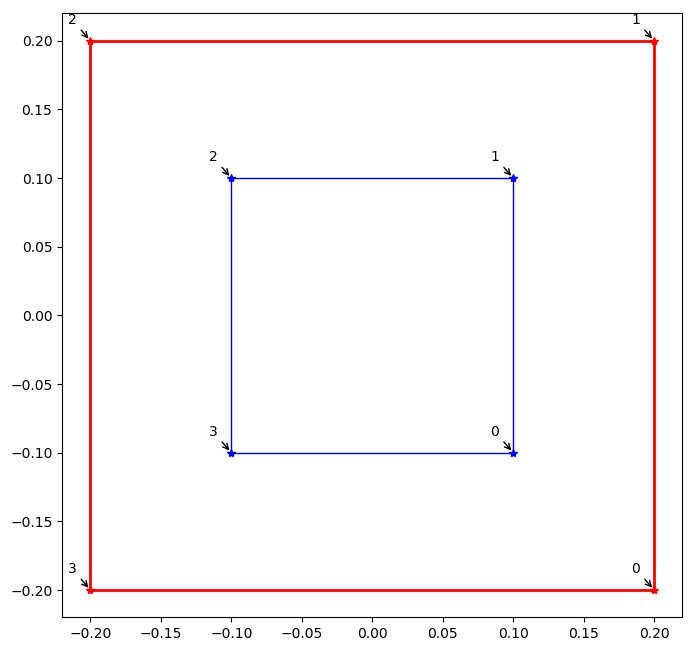

In [6]:
def chunkloop(loop, chunk_w=1.01, chunk_h=1.01, n=None, m=None):
    o = loopO(loop)
    loop = loop[o:] + loop[:o]    
    lw = round(loop[0].d(loop[ 1]), 1)
    lh = round(loop[0].d(loop[-1]), 1)
    n = (int(lw / chunk_w) - 1) if n is None else n
    m = (int(lh / chunk_h) - 1) if m is None else m
    bottom = ([loop[0]] + loop[0].line(loop[1], n) + [loop[1]])
    top    = ([loop[3]] + loop[3].line(loop[2], n) + [loop[2]])
    lines  = [([x] + x.line(y, m) + [y]) for x, y in zip(bottom, top)]
    chunks = []
    for l, r in slide(lines, 2, 1):
        for (a, b), (c, d) in zip(slide(l, 2, 1), slide(r, 2, 1)):
            chunk = [a, c, d, b]
            chunks.append(chunk)
    return chunks, lw, lh

def test():
    from meshmaker.plt import plot, plot_loop
    
    l = vec3.O().ring(0.2, 4, False)
    
    f, ax = plot()
    plot_loop(ax, l, col='r', lw=2, mk='*')
    for l in chunkloop(l)[0]:
        plot_loop(ax, loop_offset(l, 0.1), col='b', lw=1, mk='*')

test()

In [7]:
def trim(control, edges):
    edges = [(control.vertices[i], control.vertices[j]) for i, j in edges]
    positions = [u.lerp(v, 0.3) for u, v in edges]
    models = [cube_model(0.1, 'generic_9')]
    tfs = [TForm(position=p, models=models) for p in positions]
    return TForm(children=tfs)


class Wall(Base):
    
    __name__ = 'FuckingWall'
    
    def __call__(self, control, faces):
        self.ww = 0.3
        self.wh = 0.6
        self.wz = 0.2
        self.wd = 0.03
        self.wf = WindowFactory(self.ww, self.wh, self.wz, self.wd)

        mesh = Mesh()
        uv_seams = []
        children = []
        for f in faces:
            N = control.face_normals()[f]
            loop = [control.vertices[v] for v in control.faces[f]]
            chunks, w, h = chunkloop(loop)
            if w > self.ww * 1.1 and h > (self.wh + self.wz) * 1.1:
                windows = self.wf(chunks)
                for chunk, window in zip(chunks, windows.children):
                    seam = window.transform([p.cp() for p in windows.seam])
                    hole = (N * self.wd).trnps([p.cp() for p in seam]) # project seam into plane of chunk?                    
                    mesh.bridges([chunk, hole, seam], n=0, m=1)
                    a, b, c, d = (mesh._fp(hole[0]), mesh._fp(hole[1]),
                                  mesh._fp(hole[2]), mesh._fp(hole[3]))
                    uv_seams.append((a, b))
                    uv_seams.append((b, a))
                    uv_seams.append((c, d))
                    uv_seams.append((d, c))
                    children.append(windows)
            else:
                for chunk in chunks:
                    mesh.af(chunk)
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z(), seams=uv_seams)
        return TForm(models=[Model(meshes={'generic_13': [mesh]})], children=children)

In [8]:
class WindowFactory(Base):
    
    __name__ = 'wfa'
    
    def __init__(self, ww, wh, wz, wd, **kws):
        loop = [vec3(-ww / 2, wd, wz),
                vec3( ww / 2, wd, wz),
                vec3( ww / 2, wd, wz + wh),
                vec3(-ww / 2, wd, wz + wh)]
        self.wz = wz
        self.seam = loop
        self.jamb = self.make_jamb(loop)
        
    def make_jamb(self, loop, jw=0.02, jd=0.04, texture='generic_10'):
        """Hide the edges of loop with a mesh"""
        N = loop_normal(loop)
        loops = []
        loops.append((N * (jd / 2)).trnps([p.cp() for p in loop]))
        loops.append(loop_offset(loops[-1], jw))
        loops.append((N * (-jd)).trnps([p.cp() for p in loops[-1]]))
        loops.append(loop_offset(loops[-1], -jw))
        loops = [list(loop) for loop in zip(*loops)]
        loops.reverse()
        mesh = Mesh()
        patches = mesh.bridges(loops, n=1, m=0)
        mesh.uvs = {}
        for patch in patches:
            mesh.uvs = mesh.unwrap_uvs(patch[1], X=vec3.nY(),
                seams=mesh.perimeter(patch), uvs=mesh.uvs)
        return Model(meshes={texture: [mesh]})

    def __call__(self, loops):
        tfs = []
        for loop in loops:
            p = loop[0].lerp(loop[1], 0.5)
            N = loop_normal(loop)
            if isnear(N.y, -1):
                q = None
            elif isnear(N.y, 1):
                q = quat.av(-np.pi, vec3.Z())
            else:
                q = quat.uu(vec3.nY(), N)
            tfs.append(TForm(t=p, q=q, models=[self.jamb]))
        return TForm(children=tfs, seam=self.seam)

In [9]:
def make_control_mesh():
    Z = vec3.Z()
    
    mesh = Mesh()
    
    grass = MetaMesh.textured('generic_0')
    tile = MetaMesh.textured('generic_1')
    foundation = MetaMesh.textured('generic_2')

    wall = Wall(m=0)
    roof = Roof()
    entry = Entry()
    
    r = 2.5
    bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
    mesh.grid(*bottom, 4, 4, meta=grass)
    
    footprint = []
    for f, face in mesh:
        if all((mesh.e2f.get((j, i)) is not None) for i, j in slide(face, 2)):
            footprint.append(f)
            mesh.meta[f] = foundation
    
    #footprint.pop(-1)
    patches = mesh.extrude(footprint, Z * 0.2)
    for f in patches[0]:
        mesh.meta[f] = roof
            
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = tile
    mesh.meta[patches[1][-5]] = entry
    
    patches[0].pop(-1)
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
    
    patches[0].pop(-2)
    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall

    patches = mesh.extrude(patches[0], Z)
    for f in patches[1]:
        mesh.meta[f] = wall
    return mesh
    

def test():
    NewWindow(MetaMesh(make_control_mesh()))
    
#test()

In [10]:
%load_ext line_profiler

In [15]:
import os
import numpy as np
from pyrr import Matrix44
from PIL import Image
import moderngl
import moderngl_window
from moderngl_window.conf import settings
from moderngl_window.timers.clock import Timer
from meshmaker.base import Base


class LazyMaterials(Laziness):
    
    def __init__(self, ctx, **kws):
        self.textures = {}
        for r, ds, fs in os.walk('./resources/textures/'):
            for f in fs:
                name = f[:f.rfind('.')]
                path = os.path.join(r, f)
                self.textures[name] = path
        super().__init__(self.method(ctx), **kws)
    
    def __iter__(self):
        yield from self.textures.keys()
    
    def method(self, ctx):
        def wrapped(name):
            path = self.textures[name]
            img = Image.open(path)
            imgbytes = img.tobytes()
            bytesize = int(len(imgbytes) / np.product(img.size))
            print(f'Loaded texture: {name} ({path})')
            return ctx.texture(img.size, bytesize, imgbytes)
        return wrapped


class NewWindow(Base):

    vertex_shader = '''
        #version 330

        uniform mat4 Mvp;

        in vec3 in_position;
        in vec3 in_normal;
        in vec2 in_texcoord_0;

        out vec3 v_vert;
        out vec3 v_norm;
        out vec2 v_text;

        void main() {
            gl_Position = Mvp * vec4(in_position, 1.0);
            v_vert = in_position;
            v_norm = in_normal;
            v_text = in_texcoord_0;
        }
    '''
    fragment_shader = '''
        #version 330

        uniform vec3 Light;
        uniform sampler2D Texture;

        in vec3 v_vert;
        in vec3 v_norm;
        in vec2 v_text;
        
        out vec4 f_color;
        
        void main() {
            float lum = clamp(dot(normalize(Light - v_vert), normalize(v_norm)), 0.0, 1.0) * 0.3 + 0.4;
            vec3 base = vec3(0.5, 0.5, 0.5) * lum;
            vec3 spec = vec3(1.0, 1.0, 1.0) * pow(lum, 5.7);
            vec4 tex = texture(Texture, v_text);
            f_color = vec4(base * 0.1 + tex.rgb * lum + spec, tex.a);
        }
    '''
    
    def __init__(self, source):
        self.source = source
        self.targets = []
        
        settings.WINDOW['class'] = 'moderngl_window.context.pyglet.Window'
        self.wnd = moderngl_window.create_window_from_settings()
        self.wnd.key_event_func = self.key_event
        
        self.ctx = self.wnd.ctx
        self.ctx.enable(moderngl.DEPTH_TEST | moderngl.CULL_FACE)

        self.prog = self.ctx.program(
            vertex_shader=self.vertex_shader,
            fragment_shader=self.fragment_shader)
        
        self.materials = LazyMaterials(self.ctx)

        self.camera = Camera(self.prog)
        self.wnd.mouse_drag_event_func = self.camera.mouse_drag_event
        self.wnd.mouse_scroll_event_func = self.camera.mouse_scroll_event
        self.wnd.mouse_press_event_func = self.camera.mouse_press_event

        self.run()
    
    def key_event(self, key, action, modifiers):
        keys = self.wnd.keys
        if action == keys.ACTION_PRESS:
            if key == keys.Q:
                self.wnd.close()
            elif key == keys.U:
                self.update()
            elif key == keys.R:
                self.camera.reset_view()
            elif key == keys.W:
                self.ctx.wireframe = not self.ctx.wireframe
            else:
                parameters = getattr(self.source, 'parameters', {})
                operation = parameters.get(key)
                if operation is not None:
                    operation(key, action, modifiers)
                    self.update()

    def run(self):
        timer = Timer()
        timer.start()
        self.update()
        while not self.wnd.is_closing:
            self.wnd.clear()
            time, frame_time = timer.next_frame()
            self.render(time, frame_time)
            self.wnd.swap_buffers()
        self.wnd.destroy()

    def render(self, time, frame_time):
        self.ctx.clear(0.8, 0.8, 1.0)
        self.ctx.enable(moderngl.DEPTH_TEST)
        self.camera()
        for mode, texture, vao in self.targets:
            if texture is not None:
                texture.use()
            vao.render()
            vao.render(mode)

    def draw_material(self, tf, material, vertices=None, wireframe=None):
        """Recursively aggregate data from a scene graph for a material"""
        vertices = [] if vertices is None else vertices
        wireframe = [] if wireframe is None else wireframe
        if hasattr(tf, 'models'):
            for model in tf.models:
                for mesh in model.meshes.get(material, ()):
                    try:
                        tridata, wiredata = mesh.T2F_N3F_V3F(tf)
                        vertices.extend(tridata)
                        wireframe.extend(wiredata)
                    except:
                        print(f'failed to generate mesh {mesh}')
        for child in tf.children:
            self.draw_material(child, material, vertices, wireframe)
        return vertices, wireframe
        
    def update(self):
        if hasattr(self.source, 'scene'):
            self.scene = self.source.scene()
        else:
            self.scene = TForm()
            print(f'Source has no "scene" method: {self.source}')

        self.targets = []
        for name in self.materials:
            vertices, wireframe = self.draw_material(self.scene, name)
            if vertices:
                vertices = np.array(vertices)
                vbo = self.ctx.buffer(vertices.astype('f4').tobytes())
                vao = self.ctx.simple_vertex_array(self.prog, vbo,
                    'in_texcoord_0', 'in_normal', 'in_position')
                self.targets.append((moderngl.TRIANGLES, self.materials[name], vao))
            
            
            
            if False and wireframe:
                wireframe = np.array(wireframe)
                vbo = self.ctx.buffer(wireframe.astype('f4').tobytes())
                vao = self.ctx.simple_vertex_array(self.prog, vbo,
                    'in_texcoord_0', 'in_normal', 'in_position')
                self.targets.append((moderngl.LINES, None, vao))
            

                
class Camera(Base):
    
    def mouse_drag_event(self, x, y, dx, dy):
        if self._last_mouse == 1:
            look = (self.target - vec3(*self.xyz)).nrm()
            left = vec3.Z().crs(look)
            up = look.crs(left)            
            self.target += (left * dx + up * dy) * self.speed
        elif self._last_mouse == 2:
            self.theta -= dx * self.speed
            self.phi -= dy * self.speed
        
    def mouse_scroll_event(self, x_offset, y_offset):
        self.radius -= y_offset * self.speed * 10
        
    def mouse_press_event(self, x, y, button):
        self._last_mouse = button
    
    def reset_view(self):
        self.target   = vec3(0, 0, 0)
        self.radius = 10
        self.theta  = np.pi / 3
        self.phi    = np.pi / 3
        self.aspect_ratio = 16 / 9
        self.speed = 0.01

    def __init__(self, prog):
        self.mvp = prog['Mvp']
        self.light = prog['Light']
        self.reset_view()
    
    @property
    def xyz(self):
        x = self.radius * np.cos(self.theta) * np.sin(self.phi)
        y = self.radius * np.sin(self.theta) * np.sin(self.phi)
        z = self.radius * np.cos(self.phi)
        return x + self.target.x, y + self.target.y, z + self.target.z
        
    def __call__(self):
        x, y, z = self.xyz
        proj = Matrix44.perspective_projection(
            45.0, self.aspect_ratio, 0.1, 100.0)
        lookat = Matrix44.look_at(
            (            x,             y,             z),
            (self.target.x, self.target.y, self.target.z),
            (            0,             0,             1))
        self.mvp.write((proj * lookat).astype('f4').tobytes())
        self.light.value = (x, y, z)

                
def test():
    NewWindow(MetaMesh(make_control_mesh()))
    
test()

Loaded texture: generic_1 (./resources/textures/generics/generic_1.png)
Loaded texture: generic_13 (./resources/textures/generics/generic_13.png)
Loaded texture: generic_0 (./resources/textures/generics/generic_0.png)
Loaded texture: generic_2 (./resources/textures/generics/generic_2.png)
Loaded texture: generic_10 (./resources/textures/generics/generic_10.png)
Loaded texture: generic_8 (./resources/textures/generics/generic_8.png)


In [61]:
%lprun -T lprof0 -f Wall.__call__ test()

Loaded texture: wood2 (./resources/textures/wood/wood2.jpg)
Loaded texture: plywood1 (./resources/textures/wood/plywood1.jpg)
Loaded texture: grass2 (./resources/textures/nature/grass2.jpg)
Loaded texture: brick2 (./resources/textures/concrete/brick2.jpg)
Loaded texture: tile3 (./resources/textures/tile/tile3.JPG)
Loaded texture: tile6 (./resources/textures/tile/tile6.jpg)
Loaded texture: tile2 (./resources/textures/tile/tile2.jpg)
Loaded texture: orangeboxtex (./resources/textures/generic/orangeboxtex.png)

*** Profile printout saved to text file 'lprof0'. 


In [16]:
class ColumnFactory(Base):
    
    @classmethod
    def meta(cls):
        """"""
        control = Mesh()
        #tile = MetaMesh.textured('tile2')
        tile = MetaMesh.textured('generic_9')
        #wood = MetaMesh.textured('wood2')
        wood = MetaMesh.textured('generic_2')

        r, h = 1, 1
        bottom = [vec3(-r,-r, 0), vec3( r,-r, 0), vec3( r, r, 0), vec3(-r, r, 0)]
        top = [p.cp().ztrn(h) for p in bottom]
        
        control.grid(*bottom, 2, 2, meta=(cls.simple, tile))
        control.bridge(top, bottom, meta=tile)
        return MetaMesh(control)
    
    @staticmethod
    def column(r=0.1, n=16, h=1, texture='generic_0'):
        b = vec3.Z(0).ring(r, n)
        t = vec3.Z(h).ring(r, n)
        mesh = Mesh()
        mesh.bridge(b, t, m=0, e=0.00001)
        mesh.normals = mesh.vertex_normals(smooth=True)
        mesh.uvs = mesh.unwrap_uvs(Y=vec3.Z(), S=vec3(1, 1, 0))
        return [Model(meshes={texture: [mesh]})]
    
    @classmethod
    def simple(cls, control, faces):
        models = cls.column()
        columns = []
        vertices = set([v for f in faces for v in control.faces[f]])
        for v in vertices:
            p = control.vertices[v].cp()
            columns.append(TForm(t=p, models=models))
        return TForm(children=columns)


NewWindow(ColumnFactory.meta())

Loaded texture: generic_0 (./resources/textures/generics/generic_0.png)
Loaded texture: generic_9 (./resources/textures/generics/generic_9.png)
